# ML on ESDC using scikit-learn 
A DeepESDL example notebook

## Linear Regression for prediction of missing land surface temperature values from air temperature values
This notebook demonstrates how to implement Machine Learning on the Earth System Data Cube using the ML library scikit-learn. The workflow is self-contained and based on a generic use case to showcase data loading, sampling strategies, model training, model evaluation and visualisation.

Please, also refer to the DeepESDL documentation and visit the platform's website for further information!

ScaDS.AI, 2023

### Import necessary libraries
In case you experience an error due to a missing library xy, please install it via "pip install xy".

In [1]:
import math
import numpy as np
import pandas as pd
import mlflow
import xarray as xr
import dask.array as da
from xcube.core.store import new_data_store

from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split

from sklearn import metrics
import mltools as ml
from global_land_mask import globe
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import tqdm as notebook_tqdm

### Load Data (Earth System Data Cube)
We load the ESDC (*.zarr) from the s3 data store (lazy load). The ESDC consists of three dimensions (longitude, latitude, time). Out of many available cube variables, which are dask arrays, we load two ("land_surface_temperature", "air_temperature_2m"). 

In [2]:
data_store = new_data_store("s3", root="esdl-esdc-v2.1.1", storage_options=dict(anon=True))
dataset = data_store.open_data('esdc-8d-0.083deg-184x270x270-2.1.1.zarr')
# use only lst and at
ds = dataset[['land_surface_temperature', 'air_temperature_2m']]
ds

<xarray.Dataset>
Dimensions:                   (time: 1840, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 1979-01-05 ... 2018-12-31
Data variables:
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

In [3]:
ds = xr.open_zarr("../lst_small.zarr")

### Add land mask variable 
Here we exclude redundant water surface values for our use case and only consider solid Earth data for our ML analysis. We extend the ESDC by a new variable "land_mask". The mask is a data array initialized for one time slice of the ESDC. 

In [4]:
lon_grid, lat_grid = np.meshgrid(ds.lon,ds.lat)
lm0 = da.from_array(globe.is_land(lat_grid, lon_grid))
lm0

dask.array<array, shape=(2160, 4320), dtype=bool, chunksize=(2160, 4320), chunktype=numpy.ndarray>

We now extend the mask to all time slices of the ESDC.

In [5]:
lm = da.stack([lm0 for i in range(ds.dims['time'])], axis = 0)
lm

dask.array<stack, shape=(10, 2160, 4320), dtype=bool, chunksize=(1, 2160, 4320), chunktype=numpy.ndarray>

We add the mask as variable to the ESDC. The cube now consists of three equally chunked variables ("land_surface_temperature", "air_temperature_2m", "land_mask"). 

In [6]:
xdsm = ds.assign(land_mask= (['time','lat','lon'],lm.rechunk(chunks=([v for k,v in ml.get_chunk_sizes(ds)]))))
xdsm

<xarray.Dataset>
Dimensions:                   (time: 10, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 2002-05-21 ... 2002-08-01
Data variables:
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    land_mask                 (time, lat, lon) bool dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

### Plot masked data for one time slice
To do that we convert the cube into a pandas dataframe.

In [30]:
df = xdsm.sel({'time' : '2002-05-21'}).to_dataframe()
df

air_temperature_2m  land_surface_temperature  \
lat        lon                                                         
 89.958333 -179.958333          266.297180                       NaN   
           -179.875000          266.297180                       NaN   
           -179.791667          266.297180                       NaN   
           -179.708333          266.297180                       NaN   
           -179.625000          266.297180                       NaN   
...                                    ...                       ...   
-89.958333  179.625000          219.817398                       NaN   
            179.708333          219.817398                       NaN   
            179.791667          219.817398                       NaN   
            179.875000          219.817398                       NaN   
            179.958333          219.817398                       NaN   

                             time  land_mask  
lat        lon                                
 89.958333 -179.958333 2002-05-21      False  
           -179.875000 2002-05-21      False  
           -179.791667 2002-05-21      False  
           -179.708333 2002-05-21      False  
           -179.625000 2002-05-21      False  
...                           ...        ...  
-89.958333  179.625000 2002-05-21       True  
            179.708333 2002-05-21       True  
            179.791667 2002-05-21       True  
            179.875000 2002-05-21       True  
            179.958333 2002-05-21       True  

[9331200 rows x 4 columns]

Air Temperature

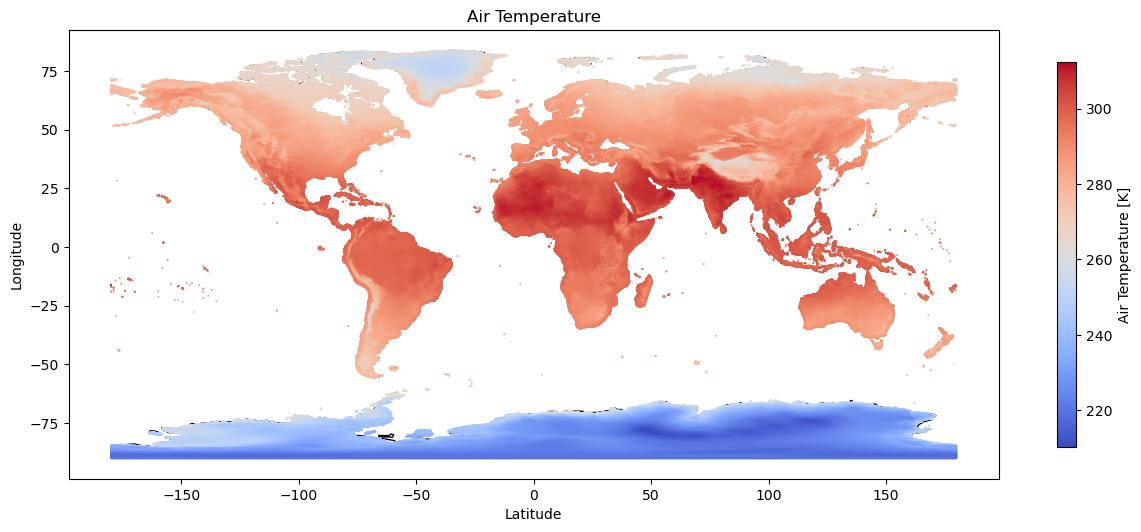

In [7]:
dfdn = df[df['land_mask'] == True]
dfdn = dfdn.reset_index()

geometry = [Point(xy) for xy in zip(dfdn['lon'], dfdn['lat'])]
gdf = GeoDataFrame(dfdn, geometry=geometry) 

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(figsize=(15, 10), markersize = 0.1,
    ax=world.plot(figsize=(15, 10), color='white', edgecolor='black'),
        column = 'air_temperature_2m', cmap = 'coolwarm', legend = True, legend_kwds={
        "shrink":.5, 'label': 'Air Temperature [K]'});

plt.title('Air Temperature');
plt.xlabel('Latitude');
plt.ylabel('Longitude');
#plt.savefig('air_temp_masked.png')

Land Surface Temperature

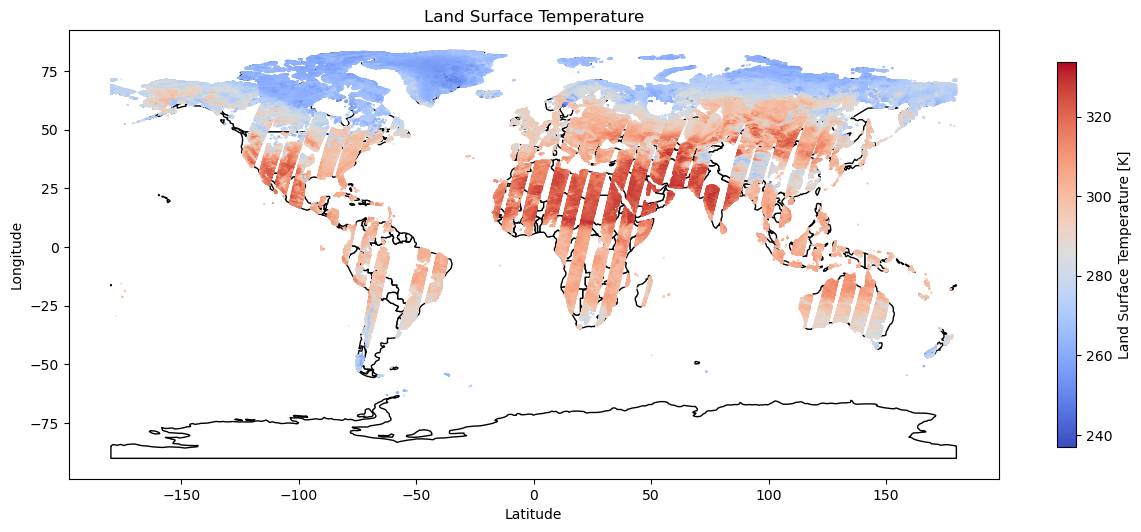

In [31]:
dfdn = df[df['land_mask'] == True]
dfdn = dfdn.reset_index()

geometry = [Point(xy) for xy in zip(dfdn['lon'], dfdn['lat'])]
gdf = GeoDataFrame(dfdn, geometry=geometry) 

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(figsize=(15, 10), markersize = 0.1,
    ax=world.plot(figsize=(15, 10), color='white', edgecolor='black'),
        column = 'land_surface_temperature', cmap = 'coolwarm', legend = True, legend_kwds={
        "shrink":.5, 'label': 'Land Surface Temperature [K]'});

plt.title('Land Surface Temperature');
plt.xlabel('Latitude');
plt.ylabel('Longitude');
#plt.savefig('land_surface_temperature.png')

### Assign train/test split
Here you can choose between random sampling and block sampling. Based on the use case, the application of ML analyses on remotely sensed data is prone to autocorrelation, especially when the data is split randomly. Block sampling is one strategy to deal with autocorrelation.

In [7]:
# random sampling
xds = xdsm.assign({"split": ml.rand})

# block sampling
# xds = ml.assign_split(xdsm, block_size=[("time", 10), ("lat", 100), ("lon", 100)], split=0.8)
xds

<xarray.Dataset>
Dimensions:                   (time: 10, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 2002-05-21 ... 2002-08-01
Data variables:
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    land_mask                 (time, lat, lon) bool dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    split                     (time, lat, lon) bool dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

Plot train/test assignment

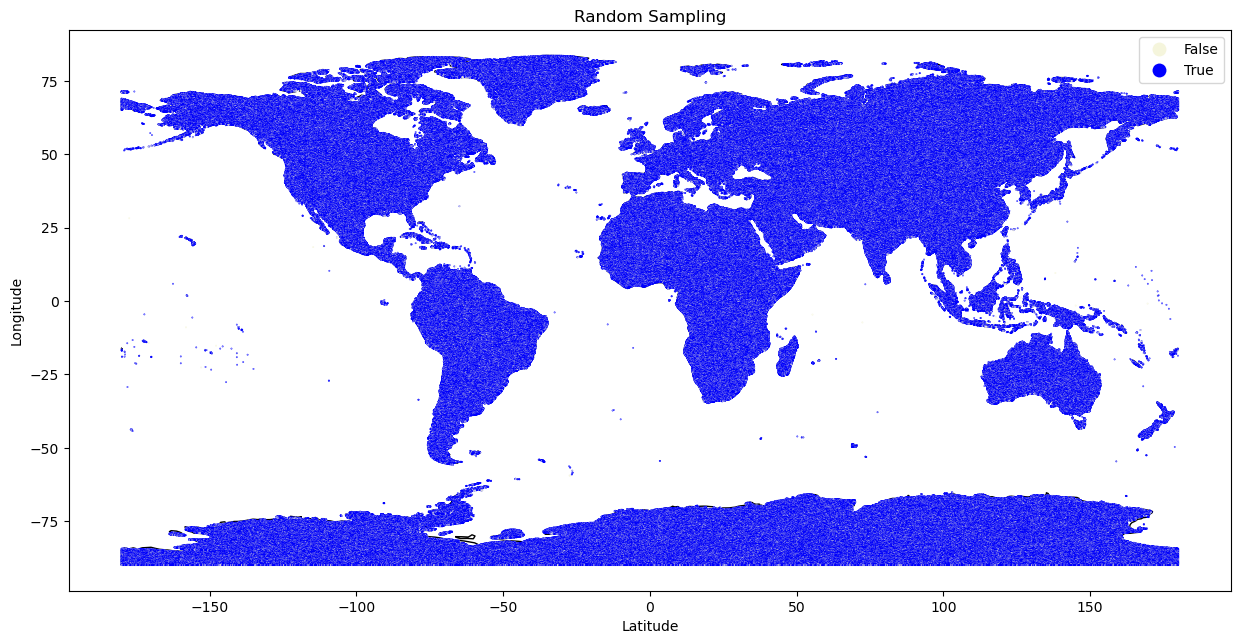

In [35]:
df = xds.sel({'time' : '2002-05-21'}).to_dataframe()

dfdn = df[df['land_mask'] == True]
dfdn = dfdn.reset_index()

geometry = [Point(xy) for xy in zip(dfdn['lon'], dfdn['lat'])]
gdf = GeoDataFrame(dfdn, geometry=geometry) 

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(figsize=(15, 10), markersize = 0.1,
    ax=world.plot(figsize=(15, 10), color='white', edgecolor='black'),
    column = 'split', cmap = LinearSegmentedColormap.from_list("", ["beige","blue"]), legend = True);

plt.title('Random Sampling');
plt.xlabel('Latitude');
plt.ylabel('Longitude');
#plt.savefig('train_test_assignment.png')

## Model set up

In [8]:
sgdreg = SGDRegressor()

Initialize MLFlow experiment

In [10]:

mlflow.sklearn.autolog()
experiment_name = "Sklearn Linear Regression of LST from AT with mlflow"
mlflow.set_experiment(experiment_name)

current_experiment=dict(mlflow.get_experiment_by_name(experiment_name))
experiment_id = current_experiment['experiment_id']

Get range (min, max) and statistics (mean, std) of data variables for normalization or standardization.

In [11]:
at_range = ml.getRange(ds, 'air_temperature_2m')
lst_range = ml.getRange(ds, 'land_surface_temperature')

#at_stat = ml.getStatistics(ds, 'air_temperature_2m')
#lst_stat = ml.getStatistics(ds, 'land_surface_temperature')

### Train model
We iterate through the chunks of the ESDC. The data will be preprocessed by flattening, choosing values, removing NaNs, normalization or standardization. Further, we will split the data into a training and testing fraction. We generate a train data loader and a test data loader and perform a linear regression. The train and test errors are returned during model training.

In [12]:
with mlflow.start_run(experiment_id=experiment_id) as run:
    for chunk in ml.iter_data_var_blocks(xds): 
        ### preprocessing
        cf = {x: chunk[x].ravel() for x in chunk.keys()}
        lm = cf['land_mask']
        cft = {x: cf[x][lm == True] for x in cf.keys()}
        lst = cft['land_surface_temperature']
        cfn = {x: cft[x][~np.isnan(lst)] for x in cft.keys()}
        if len(cfn['land_surface_temperature']) > 0:
            X = ml.normalize(cfn['air_temperature_2m'], *at_range)
            y = ml.normalize(cfn['land_surface_temperature'], *lst_range)
            
            ### get train/test data 
            X_train = X[cfn['split']==True]
            X_test  = X[cfn['split']==False]
            y_train = y[cfn['split']==True]
            y_test  = y[cfn['split']==False]
            ### train model
            if len(X_train) > 0:
                sgdreg.fit(X_train.reshape(-1, 1), y_train)

                y_pred_train = sgdreg.predict(X_train.reshape(-1, 1))
                mse_train = metrics.mean_squared_error(y_train, y_pred_train)
                print(f"Training Error: {mse_train:>8f}")
                
                if len(X_test) > 0:
                    y_pred_test = sgdreg.predict(X_test.reshape(-1, 1))
                    mse_test  = metrics.mean_squared_error(y_test, y_pred_test)
            
                    print(f"Test Error: {mse_test:>8f}\n")

Training Error: 0.003420
Test Error: 0.003426

Training Error: 0.003383
Test Error: 0.003376

Training Error: 0.002966
Test Error: 0.002990

Training Error: 0.001884
Test Error: 0.001882

Training Error: 0.001653
Test Error: 0.001657

Training Error: 0.000923
Test Error: 0.000928

Training Error: 0.001421
Test Error: 0.001429

Training Error: 0.002073
Test Error: 0.002075

Training Error: 0.002524
Test Error: 0.002439

Training Error: 0.002345
Test Error: 0.002368

Training Error: 0.002331
Test Error: 0.002322

Training Error: 0.001970
Test Error: 0.001962

Training Error: 0.002020
Test Error: 0.002026

Training Error: 0.002870
Test Error: 0.002888

Training Error: 0.002707
Test Error: 0.002703

Training Error: 0.002260
Test Error: 0.002243

Training Error: 0.003483
Test Error: 0.003524

Training Error: 0.003254
Test Error: 0.003257

Training Error: 0.003249
Test Error: 0.003261

Training Error: 0.003753
Test Error: 0.003741

Training Error: 0.003462
Test Error: 0.003492

Training Erro

### Model Predictions

Get Air Temperature values for Lon/Lat with missing Land Surface Temperature values

In [13]:
df = xds.sel({'time' : '2002-05-21'}).to_dataframe()
df

air_temperature_2m  land_surface_temperature  \
lat        lon                                                         
 89.958333 -179.958333          266.297180                       NaN   
           -179.875000          266.297180                       NaN   
           -179.791667          266.297180                       NaN   
           -179.708333          266.297180                       NaN   
           -179.625000          266.297180                       NaN   
...                                    ...                       ...   
-89.958333  179.625000          219.817398                       NaN   
            179.708333          219.817398                       NaN   
            179.791667          219.817398                       NaN   
            179.875000          219.817398                       NaN   
            179.958333          219.817398                       NaN   

                             time  land_mask  split  
lat        lon                                       
 89.958333 -179.958333 2002-05-21      False   True  
           -179.875000 2002-05-21      False  False  
           -179.791667 2002-05-21      False   True  
           -179.708333 2002-05-21      False   True  
           -179.625000 2002-05-21      False  False  
...                           ...        ...    ...  
-89.958333  179.625000 2002-05-21       True   True  
            179.708333 2002-05-21       True   True  
            179.791667 2002-05-21       True   True  
            179.875000 2002-05-21       True   True  
            179.958333 2002-05-21       True   True  

[9331200 rows x 5 columns]

Predict missing Land Surface Temperature values from Air Temperature values

In [14]:
dfl = df[df['land_mask'] == True]
orig = dfl.dropna()
to_pred = dfl[np.isnan(dfl['land_surface_temperature'])]
output = to_pred.drop('land_surface_temperature', axis = 1)

X = ml.normalize(to_pred['air_temperature_2m'], *at_range)
X = X.values

lstp = sgdreg.predict(X.reshape(-1, 1))
output['land_surface_temperature'] = ml.undo_normalizing(lstp, *lst_range)
output

air_temperature_2m       time  land_mask  split  \
lat        lon                                                            
 83.208333 -73.958333           266.152954 2002-05-21       True   True   
 83.125000 -77.041667           265.867096 2002-05-21       True   True   
           -76.958333           265.832367 2002-05-21       True   True   
           -76.875000           265.832367 2002-05-21       True  False   
           -76.791667           265.832367 2002-05-21       True   True   
...                                    ...        ...        ...    ...   
-89.958333  179.625000          219.817398 2002-05-21       True   True   
            179.708333          219.817398 2002-05-21       True   True   
            179.791667          219.817398 2002-05-21       True   True   
            179.875000          219.817398 2002-05-21       True   True   
            179.958333          219.817398 2002-05-21       True   True   

                        land_surface_temperature  
lat        lon                                    
 83.208333 -73.958333                 273.402692  
 83.125000 -77.041667                 273.338776  
           -76.958333                 273.331010  
           -76.875000                 273.331010  
           -76.791667                 273.331010  
...                                          ...  
-89.958333  179.625000                263.042292  
            179.708333                263.042292  
            179.791667                263.042292  
            179.875000                263.042292  
            179.958333                263.042292  

[1739067 rows x 5 columns]

### Plot Predictions

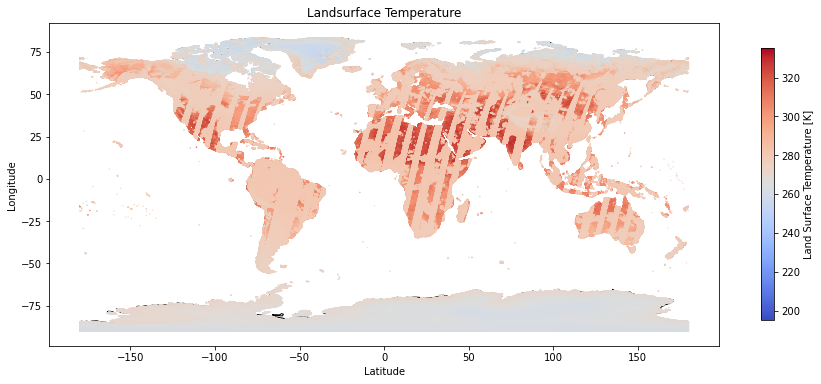

In [17]:
df = pd.concat([orig['land_surface_temperature'], output['land_surface_temperature']])
lst = df.reset_index()

geometry = [Point(xy) for xy in zip(lst['lon'], lst['lat'])]
gdf = GeoDataFrame(lst, geometry=geometry) 

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(figsize=(15, 10), markersize = 0.1,
    ax=world.plot(figsize=(15, 10), color='white', edgecolor='black'),
    column = 'land_surface_temperature', cmap = 'coolwarm', vmin = 195, vmax = 335, legend = True, 
    legend_kwds={"shrink":.5, 'label': 'Land Surface Temperature [K]'});

plt.title('Landsurface Temperature');
plt.xlabel('Latitude');
plt.ylabel('Longitude');
#fname = 'xxx' +'.png'
#plt.savefig(fname)
plt.show()

## Launch MLFlow UI

In [ ]:
!mlflow ui 
#visit https://mlflow-8a63c7.deep.earthsystemdatalab.net/
#this can be done in terminal simultaneously to calculating epochs

[2023-05-03 14:02:51 +0000] [7006] [INFO] Starting gunicorn 20.1.0
[2023-05-03 14:02:51 +0000] [7006] [INFO] Listening at: http://127.0.0.1:5000 (7006)
[2023-05-03 14:02:51 +0000] [7006] [INFO] Using worker: sync
[2023-05-03 14:02:51 +0000] [7007] [INFO] Booting worker with pid: 7007
[2023-05-03 14:02:51 +0000] [7008] [INFO] Booting worker with pid: 7008
[2023-05-03 14:02:51 +0000] [7009] [INFO] Booting worker with pid: 7009
[2023-05-03 14:02:51 +0000] [7010] [INFO] Booting worker with pid: 7010
